# ST4 MDS : TP 1 Model Based Agent

![CentraleSupelec Logo](https://www.centralesupelec.fr/sites/all/themes/cs_theme/medias/common/images/intro/logo_nouveau.jpg)

## But du TP : 
Quantifier l’influence de stratégies sur la dynamique des
prix: 
* 1. Créer un prix avec rendements aléatoires de variance
donnée
* 2. Ajouter un groupe d’agents qui utilisent une stratégie
donnée
* 3. Mesurer l’influence de l’utilisation de cette stratégie sur la
dynamique des rendements
* 4. Idem avec plusieurs stratégies et plusieurs groupes

In [1]:
import numpy as np 
import random as rd 
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm

In [2]:
__author__ = "Colleville Tanguy, Matthieu Briet"
__copyright__ = "None"
__credits__ = ["None"]
__license__ = "None"
__version__ = "1.0.0"
__maintainer__ = "Colleville Tanguy, Matthieu Briet"
__email__ = "tanguy.colleville@student-cs.fr, matthieu.briet@student-cs.fr"
__status__ = "Dev"

## 1. Créer un prix aléatoire

In [3]:
np.random.seed(0)

On ajoute un bruit: $$\epsilon_{t} \sim \mathcal{N}(\mu=0,\,\sigma^{2}=1)$$ tel que le log-prix soit donné par :
$$ p_{t+1}=p_{t}+\epsilon_{t+1}$$

In [4]:
NIT=1000 ### nombre d'itérations 
epsilon=np.random.normal(size=NIT)## vecteur de longueur NIT d'une VA N(0,1)
P_0=1 ## prix initial 
p_0=np.log(P_0)
p_t=p_0+np.cumsum(epsilon)
color=['blue','yellow','red','green','black','orange','pink','grey','brown','purple']

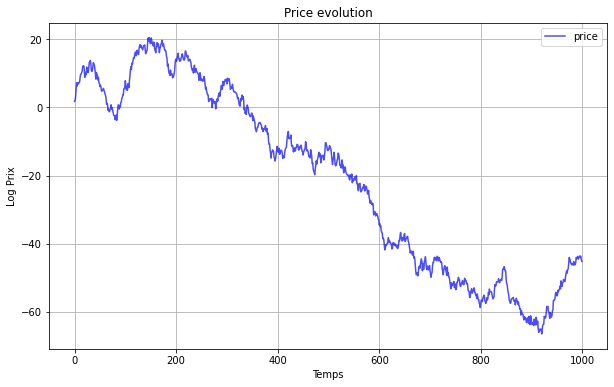

In [5]:
plt.figure(figsize=(10,6))
plt.plot(p_t,c="blue",alpha=0.7,label="price")
# plt.plot(pd.Series(p_t).rolling(5).mean(),c="red",alpha=0.7,label="mean")
plt.title("Price evolution")
plt.xlabel("Temps")
plt.ylabel("Log Prix")
plt.legend()
plt.grid()
plt.show()

## 2. Mélange d’agents aléatoires et stratégiques

Stratégie 1 : Moyenne mobile -> suivi de tendance

On ajoute ici un agent stratégique de poids $\phi_{​​​​​​​1}​​​​​​​$ et on définit une stratégie ainsi:
$$\omega_{1,t+1}=\phi_1\cdot a_{1,t}(information_{t-1})$$ avec dans le cas de moyenne mobile retenue : $a_{1,t}=signe(p_{t}-MA_{k,t})$ sachant que $MA_{k,t}=\frac{1}{k} \cdot \sum_{i=1}^{k-1} p_{t-i} $

 

Le prix sera maintenant donné par $p_{t+1}=p_{t}+\epsilon_{t+1}+\omega_{t+1}=p_{t}+r_{t+1}$ avec $r_{t}=\epsilon_{t}+\omega_{t}$

In [19]:
def Strat_moyenne(weigth_a,k=50): 
  """
  Entrées : Weight_a: float/int le poids à accorder à la méthode
  k : int la période de glissement, doit-être un entier
  ====================================================================
  But : Calcul avec la méthode de la moyenne pour un poids a
  ====================================================================
  Sorties : le nouveau prix conformément à la méthode moyenne glissante : une liste 
            et le retour sous forme de liste 
  """
  r_t=[0]*k
  p_new=p_t[:k].tolist()
  for i in range(k,NIT):
      omega=np.sign(p_new[-1]-np.mean(p_new[i-k:]))
      r_t.append(epsilon[i]+weigth_a*omega)
      p_new.append(p_new[-1]+r_t[-1])
  return p_new,r_t

## 3. Mesurer l’influence de cette stratégie

### 3.1 stratégie moyenne mobile suivi de tendance

In [7]:
W=np.linspace(0,0.5,5)## les différents poids 

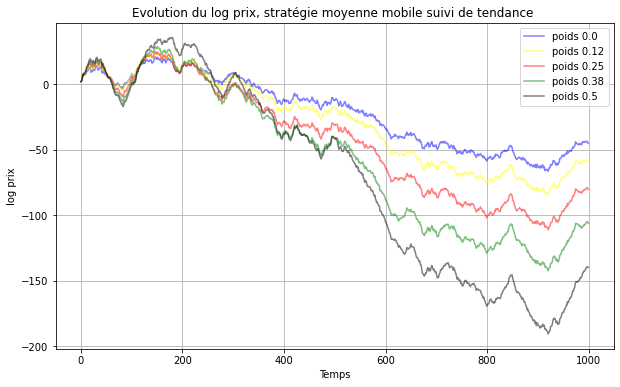

In [8]:
plt.figure(figsize=(10,6))
for index,w in enumerate(W):
    plt.plot(Strat_moyenne(w)[0],c=color[index],label=f"poids {round(w,2)}",alpha=0.5)
plt.title("Evolution du log prix, stratégie moyenne mobile suivi de tendance ")
plt.xlabel("Temps")
plt.ylabel("log prix")
plt.grid()
plt.legend()
plt.show()

In [9]:
for index,w in enumerate(W):
    print(f"variance de r pour poids {round(w,2)}: \u03C3² = ",round(np.var(Strat_moyenne(w)[1]),4))

variance de r pour poids 0.0: σ² =  0.9608
variance de r pour poids 0.12: σ² =  0.9752
variance de r pour poids 0.25: σ² =  1.0197
variance de r pour poids 0.38: σ² =  1.0882
variance de r pour poids 0.5: σ² =  1.2038


On constate que la variance augmente avec le poids accordé à la stratégie suivie de tendance ce qui montre une amplitude de variation plus grande des log prix.

<Figure size 720x432 with 0 Axes>

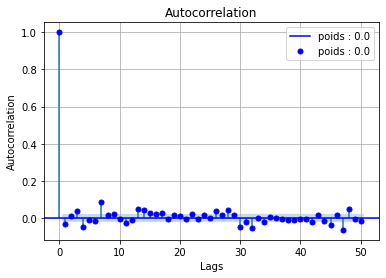

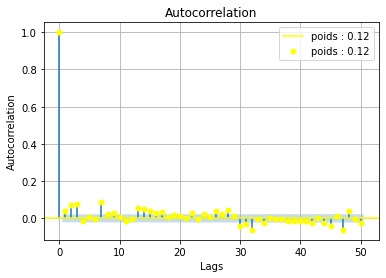

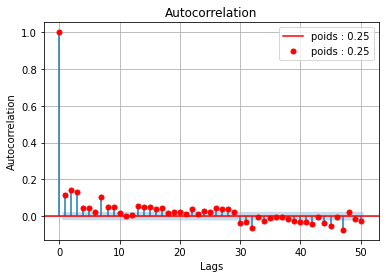

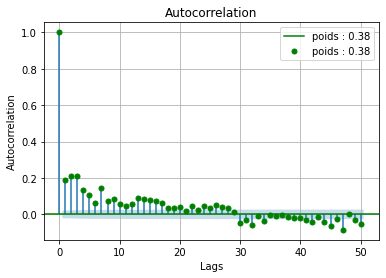

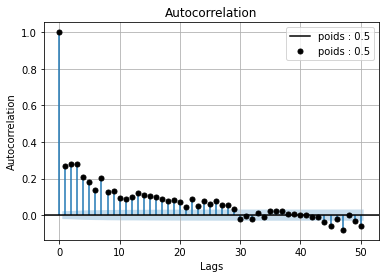

In [10]:
plt.figure(figsize=(10,6))
k=5
for index,w in enumerate(W):
    sm.graphics.tsa.plot_acf(Strat_moyenne(w)[1],lags=10*k,color=color[index],label=f"poids : {round(w,2)}",alpha=0.5)
    plt.title("Autocorrelation")
    plt.xlabel("Lags")
    plt.ylabel("Autocorrelation")
    plt.grid()
    plt.legend()
plt.show()

Un diagramme d'autocorrélation permet d'analyser si les données sont statistiquement signifiantes. Dans le cas où le pic est dehors de la bande bleu, cela veut dire qu'il est statistiquement signifiant. On peut alors voir que plus le poids augmente plus le nombre de termes statistiquement signifiants augmente et c'est normal puisqu'on donne plus d'importance à la stratégie suivie de moyenne qui se bases sur des valeurs passées,donc les corrélations sont plus fortes. 

### Autocorrelation à un pas

On va à présent calculer l'autocorrelation $C(\tau)=\frac {E(r_{t}r_{t+\tau})-E(r_{t})^2}{Var(r_t)} $

In [11]:
def autocorr(x):
    """
    Entrée(s) : un np.array() ou liste du return notamment
    ========================================
    But: Calculer l'autocorrélation à un pas d'une série temporelle
    ========================================
    Sortie(s) : l'autocorrélation de la série temporelle sous forme de np.array()
    """
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:] ## reshaping pour obtenir la longueur adéquate


No handles with labels found to put in legend.


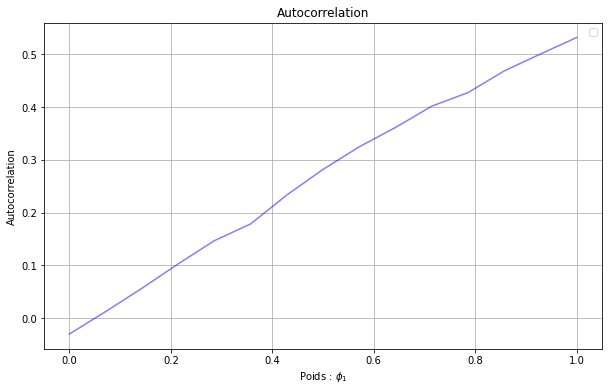

In [12]:
plt.figure(figsize=(10,6))
k=5
auto=[]
W=np.linspace(0,1,15)
for i in W:
    autop=autocorr(Strat_moyenne(i)[1])
    auto.append(autop[1]/float(autop.max()))
plt.plot(W,auto,color="blue",alpha=0.5)
plt.title("Autocorrelation")
plt.xlabel("Poids : ${\phi}_{1}$")
plt.ylabel("Autocorrelation")
plt.grid()
plt.legend()
plt.show()

On peut voir que le plus le poids accordé à la stratégie de moyenne glissante augmente plus l'autocorrélation est importante ce qui vient confirmer ce qu'on a pu voir sur les diagrammes d'autocorrélation. Le lien se renforce avec le poids puisqu'on y accorde plus d'importance et donc de lien etant donné la stratégie de moyenne glissante.
La tendance est devenue prévisible dans la mesure où l'autocorrélation atteint 50% pour un poids important. Cependant, on remarque également une augmentation de la variance ce qui montre également une importante variation. De plus, on notera qu'il est facile de détecter un agent qui utilise la méthode des moyennes glissantes.

No handles with labels found to put in legend.


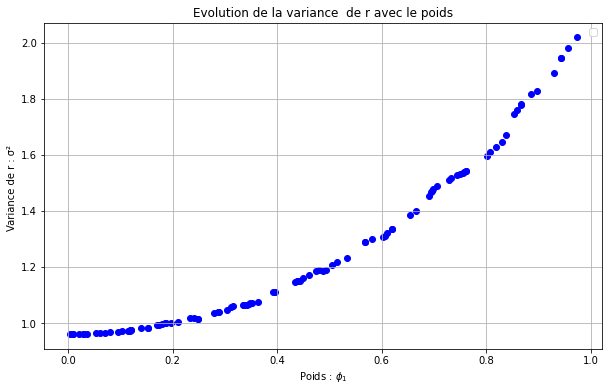

In [13]:
plt.figure(figsize=(10,6))
long=100
phi_1=[rd.random() for i in range(long)]## les différents poids 
Var=[np.var(Strat_moyenne(phi_1[i])[1]) for i in range(long)]
plt.scatter(phi_1,Var,c="blue",label="")
plt.title("Evolution de la variance  de r avec le poids")
plt.xlabel("Poids : ${\phi}_{1}$")
plt.ylabel("Variance de r : \u03C3² ")
plt.grid()
plt.legend()
plt.show()

Ici on remarque que la stratégie moyenne glissante vient augmenter les amplitudes de variation des returns, ce qu'on peut également voir sur les premières graphiques avec les logs-prix.  

## 4. Plusieurs stratégies, plusieurs groupes


On sait que $$ {p}_{t+1} = {p}_{t}+I({A}_{t})$$  or $$ I({A}_{t})={A}_{t}$$ et $${A}_{t} = \sum {a}_{i,t}  $$ avec $a_{i,t}$ la stratégie de chaque agent au temps t.

In [14]:
k_pop_1=10
k_pop_2=5
long=35
phi_1=np.linspace(0,1,long)
phi_2=np.linspace(0,1,long)

In [15]:
def Strat_moyenne_bipop(weight_1,weight_2,k_1,k_2):
  """
  Entrées : Weight_1 / 2: float/int le poids à accorder à la méthode propre à chaque population
  k_1/2 : int la période de glissement, doit-être un entier, propre à chaque population
  ====================================================================
  But : Calcul avec la méthode de la moyenne pour la présence de deux populations à stratégies opposées
  ====================================================================
  Sorties : le nouveau prix conformément à la méthode moyenne glissante : une liste 
            et le retour sous forme de liste 
  """
  k=max(k_1,k_2)
  r_t=[0]*k
  p_new=p_t[:k].tolist()
  for i in range(k,NIT):
    omega1=np.sign(p_new[-1]-np.mean(p_new[i-k_1:]))
    omega2=-np.sign(p_new[-1]-np.mean(p_new[i-k_2:]))# signe - pour prendre la stratégie opposée
    r_t.append(epsilon[i]+weight_1*omega1+weight_2*omega2)
    p_new.append(p_new[-1]+r_t[-1])
  return p_new,r_t

In [16]:
var=np.zeros((long,long))## calcul brut force de notre matrice
for i in range(long):
    for j in range(long):
        var[i][j]=(np.var(Strat_moyenne_bipop(phi_1[i],phi_2[j],k_pop_1,k_pop_2)[1]))

No handles with labels found to put in legend.


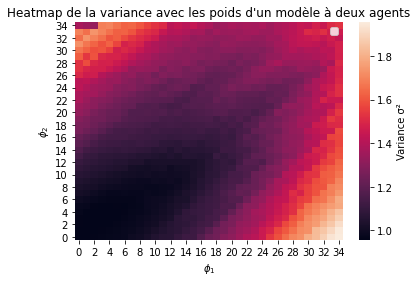

In [57]:
sns.heatmap(var,cbar_kws={'label': 'Variance \u03C3²'}).invert_yaxis()
plt.title("Heatmap de la variance avec les poids d'un modèle à deux agents")
plt.xlabel("${\phi}_{1}$")
plt.ylabel("${\phi}_{2}$")
plt.legend()
plt.show()

No handles with labels found to put in legend.


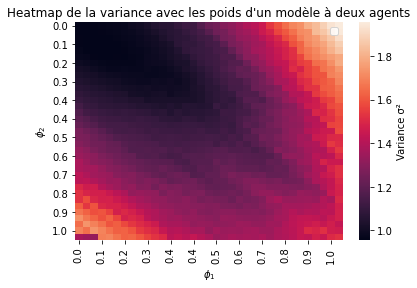

In [55]:
# sns.clustermap(var)
xlabels = ['{:3.1f}'.format(x) for x in phi_1]
ylabels = ['{:3.1f}'.format(y) for y in phi_2]
ax = sns.heatmap(var, xticklabels=xlabels, yticklabels=ylabels,cbar_kws={'label': 'Variance \u03C3²'})
ax.set_xticks(ax.get_xticks()[::3])
ax.set_xticklabels(xlabels[::3])
ax.set_yticks(ax.get_yticks()[::3])
ax.set_yticklabels(ylabels[::3])
plt.title("Heatmap de la variance avec les poids d'un modèle à deux agents")
plt.xlabel("${\phi}_{1}$")
plt.ylabel("${\phi}_{2}$")
plt.legend()
plt.show()

Plus les phi sont différents, i.e. plus il y a un déséquilibre marqué entre les agents, plus la variance est élevée;ce qui entraine une variation importante des log-prix. 
A poids égale, les actions se "compensent" permettent d'avoir une variance faible comparativement au maximum observé.
On notera tout de même que la variance est la plus faible lorsque $\phi_{1}$ & $\phi_{2} $ sont inférieurs à 0.4. Ceci s'explique par le fait que pour chaque agent, il s'agit de configuration où il y a le moins de variance. 

In [18]:
auto_corr_bipop=[]
for phi_1i in phi_1:
    tampon=[]
    for phi_2i in phi_2:
        z=autocorr(Strat_moyenne_bipop(phi_1i,phi_2i,k_pop_1,k_pop_2)[1])
        tampon.append(z[1]/float(z.max()))
    auto_corr_bipop.append(tampon)

No handles with labels found to put in legend.


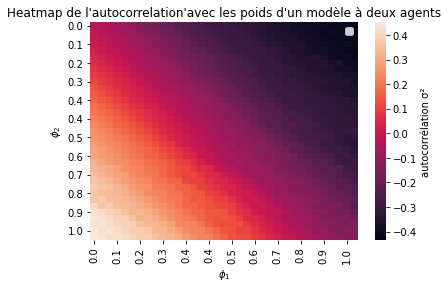

In [52]:
# sns.clustermap(auto_corr_bipop) # est-ce mieux ? 
xlabels = ['{:3.1f}'.format(x) for x in phi_1]
ylabels = ['{:3.1f}'.format(y) for y in phi_2]
ax = sns.heatmap(auto_corr_bipop, xticklabels=xlabels, yticklabels=ylabels,cbar_kws={'label': 'autocorrélation \u03C3²'})
ax.set_xticks(ax.get_xticks()[::3])
ax.set_xticklabels(xlabels[::3])
ax.set_yticks(ax.get_yticks()[::3])
ax.set_yticklabels(ylabels[::3])
plt.title("Heatmap de l'autocorrelation'avec les poids d'un modèle à deux agents")
plt.xlabel("${\phi}_{1}$")
plt.ylabel("${\phi}_{2}$")
plt.legend()
plt.show()

On peut voir que lorsque les $\phi$ sont égaux, l'autocorrélation est nulle ce qui rend l'évolution du prix imprévisible. 

On note certains cas particuliers, à savoir deux zones : 
* 1. Lorsque $\phi_1$ est faible et $\phi_2$  fort, l'autocorrélation est proche de 0.4 . Dans ce cas précis, on est presque ramené au cas où on a un seul agent et on retrouve le résultat précédent.
* 2. Lorsque $\phi_1$ est fort et $\phi_2$  faible, on a la même chose ( avec une valeur de l'autoccorélation opposée)

# Conclusion 

Au travers de ce tp nous avons pu nous rendre compte de l’influence de stratégies (une ou deux opposées) sur la dynamique des
prix.